In [3]:
import numpy as np
import networkx as nx
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

# Générer un graphe SBM
def generate_sbm_graph(sizes, p_matrix):
    """
    Génère un graphe SBM (Stochastic Block Model).
    
    Arguments :
   
    sizes : list - Taille de chaque communauté.
    p_matrix : ndarray - Matrice de probabilités inter/intra-blocs.
    
    Retourne :
    G : networkx.Graph - Graphe généré.
    """
    G = nx.stochastic_block_model(sizes, p_matrix)
    return G

# Convertir le graphe en matrice d'adjacence
def graph_to_adjacency_matrix(G):
    """
    Convertit un graphe en une matrice d'adjacence.
    """
    return nx.adjacency_matrix(G).toarray()

# Détection des communautés via factorisation matricielle
def detect_communities_via_matrix_factorization(adj_matrix, k):
    """
    Détecte les communautés en utilisant la factorisation des matrices
    et la minimisation Alternating Mean Squares.
    
    Arguments :
    adj_matrix : ndarray - Matrice d'adjacence.
    k : int - Nombre de communautés à détecter.
    
    Retourne :
    clusters : ndarray - Matrice indiquant l'appartenance aux communautés.
    """
    # Initialisation des matrices
    n = adj_matrix.shape[0]
    U = np.random.rand(n, k)
    V = np.random.rand(k, n)
    
    # Alternating Least Squares
    max_iter = 50
    tol = 1e-4
    for iteration in range(max_iter):
        # Fixer V, mettre à jour U
        U = np.linalg.solve(np.dot(V, V.T), np.dot(V, adj_matrix.T)).T
        U = np.maximum(U, 0)  # Assurer la non-négativité
        
        # Fixer U, mettre à jour V
        V = np.linalg.solve(np.dot(U.T, U), np.dot(U.T, adj_matrix))
        V = np.maximum(V, 0)  # Assurer la non-négativité
        
        # Calculer l'erreur
        reconstruction = np.dot(U, V)
        error = np.linalg.norm(adj_matrix - reconstruction, 'fro')
        if error < tol:
            print(f"Convergence atteinte à l'itération {iteration}.")
            break
    # Calculer goodness of fit (R^2)
    adj_mean = adj_matrix.mean()
    total_variance = np.sum((adj_matrix - adj_mean) ** 2)
    residual_variance = np.sum((adj_matrix - reconstruction) ** 2)
    r_squared = 1 - residual_variance / total_variance
    
    # Attribuer les communautés
    clusters = np.argmax(U, axis=1)
    return clusters

def detect_communities_via_matrix_factorizationMU(adj_matrix, k):
    """
    Détecte les communautés en utilisant la factorisation des matrices
    et la minimisation Alternating Mean Squares.
    
    Arguments :
    adj_matrix : ndarray - Matrice d'adjacence.
    k : int - Nombre de communautés à détecter.
    
    Retourne :
    clusters : ndarray - Matrice indiquant l'appartenance aux communautés.
    """
    # Initialisation des matrices
    n = adj_matrix.shape[0]
    U = np.random.rand(n, k)
    V = np.random.rand(k, n)
    
    # Alternating Least Squares
    max_iter = 50
    tol = 1e-4
    for iteration in range(max_iter):
        # Mise à jour de U
        U_num = np.dot(adj_matrix, V.T)
        U_den = np.dot(np.dot(U, V), V.T) + 1e-10  # Éviter la division par zéro
        U *= U_num / U_den

        # Mise à jour de V
        V_num = np.dot(U.T, adj_matrix)
        V_den = np.dot(U.T, np.dot(U, V)) + 1e-10  # Éviter la division par zéro
        V *= V_num / V_den
        
        # Calculer l'erreur
        reconstruction = np.dot(U, V)
        error = np.linalg.norm(adj_matrix - reconstruction, 'fro')
        if error < tol:
            print(f"Convergence atteinte à l'itération {iteration}.")
            break
    # Calculer goodness of fit (R^2)
    adj_mean = adj_matrix.mean()
    total_variance = np.sum((adj_matrix - adj_mean) ** 2)
    residual_variance = np.sum((adj_matrix - reconstruction) ** 2)
    r_squared = 1 - residual_variance / total_variance
    
    # Attribuer les communautés
    clusters = np.argmax(U, axis=1)
    return clusters

Modularity (tooo slow)

In [5]:
# Calcul de la modularité
def compute_modularity(G, communities):
    """
    Calcule la modularité d'un graphe donné et des communautés détectées.
    
    Arguments :
    G : networkx.Graph - Le graphe.
    communities : ndarray - Attribution des communautés pour chaque nœud.
    
    Retourne :
    modularity : float - Valeur de la modularité.
    """
    m = G.size(weight='weight')  # Nombre total d'arêtes
    modularity = 0.0
    
    # Calculer la contribution de chaque paire de nœuds
    for i in G.nodes: 
        for j in G.nodes:
            if communities[i] == communities[j]:  # Même communauté
                A_ij = 1 if G.has_edge(i, j) else 0
                ki = G.degree(i, weight='weight')
                kj = G.degree(j, weight='weight')
                modularity += A_ij - (ki * kj) / (2 * m)
    
    modularity /= (2 * m)
    return modularity

In [6]:
def nxModularity(G,communities):
    from collections import defaultdict
    # Group nodes by their community label
    community_dict = defaultdict(set)
    for node, label in enumerate(communities):
        community_dict[label].add(node)

    # Convert dictionary values to a list of sets
    communities_new = list(community_dict.values())
    return nx.algorithms.community.quality.modularity(G, communities_new)
    


In [ ]:
import time


sizes = [300, 300, 300]  # 3 communautés
p_matrix = np.array([
        [0.8, 0.05, 0.02],
        [0.05, 0.7, 0.04],
        [0.02, 0.04, 0.9]
    ])
    
    # Générer le graphe
G = generate_sbm_graph(sizes, p_matrix)
    
    # Matrice d'adjacence
adj_matrix = graph_to_adjacency_matrix(G)
    
# Détecter les communautés
k = 3  # Nombre de communautés

#minimisation avec mise à jour multiplicative
# Début du chronométrage
start_time = time.time()
communities = detect_communities_via_matrix_factorizationMU(adj_matrix, k)
end_time = time.time()
# Temps écoulé
execution_time = end_time - start_time
print(f"Temps d'exécution en utilisant MU : {execution_time:.6f} secondes")


#calculer la modularité manuellement
start_time = time.time()
print('modularity: ',compute_modularity(G, communities))
end_time = time.time()
# Temps écoulé
execution_time = end_time - start_time
print(f'time to compute modularity : {execution_time} secondes')

#calculer la modularité avec networkix
start_time = time.time()
from collections import defaultdict
# Group nodes by their community label
community_dict = defaultdict(set)
for node, label in enumerate(communities):
    community_dict[label].add(node)

# Convert dictionary values to a list of sets
communities = list(community_dict.values())
print('modularity: ',nx.algorithms.community.quality.modularity(G, communities))
end_time = time.time()
# Temps écoulé
execution_time = end_time - start_time
print(f'time to compute modularity using nx : {execution_time} secondes')

#minimisation avec np.solve
# Début du chronométrage
start_time = time.time()
communities = detect_communities_via_matrix_factorization(adj_matrix, k)
end_time = time.time()
# Temps écoulé
execution_time = end_time - start_time
print(f"Temps d'exécution en utilisant np.solve : {execution_time:.6f} secondes")

#calculer la modularité avec networkix
start_time = time.time()
from collections import defaultdict
# Group nodes by their community label
community_dict = defaultdict(set)
for node, label in enumerate(communities):
    community_dict[label].add(node)

# Convert dictionary values to a list of sets
communities = list(community_dict.values())
print('modularity: ',nx.algorithms.community.quality.modularity(G, communities))
end_time = time.time()
# Temps écoulé
execution_time = end_time - start_time
print(f'time to compute modularity using nx : {execution_time} secondes')

Temps d'exécution en utilisant MU : 1.186418 secondes
modularity:  0.5797661108960864
time to compute modularity : 8.45887804031372 secondes
modularity:  0.5797661108960664
time to compute modularity using nx : 0.046927452087402344 secondes
Temps d'exécution en utilisant np.solve : 0.620485 secondes
modularity:  0.5797661108960664
time to compute modularity using nx : 0.04369330406188965 secondes


LinAlgError: Last 2 dimensions of the array must be square

Nombre de communautés optimal 

In [41]:
# Itérer sur différentes valeurs de k
def find_best_community_partition(G, adj_matrix, k_values):
    best_modularity = -1
    best_communities = None
    best_k = None
    
    for k in k_values:
        communities = detect_communities_via_matrix_factorization(adj_matrix, k)
        modularity = nxModularity(G, communities)
        print(f"Nombre de communautés (k={k}) : Modularity = {modularity:.4f}")
        
        if modularity > best_modularity:
            best_modularity = modularity
            best_communities = communities
            best_k = k
    
    return best_k, best_communities, best_modularity

In [42]:
G=sizes = [300, 300, 300]  # 3 communautés
p_matrix = np.array([
        [0.8, 0.05, 0.02],
        [0.05, 0.7, 0.04],
        [0.02, 0.04, 0.9]
    ])
    
    # Générer le graphe
G = generate_sbm_graph(sizes, p_matrix)
k_values = range(2, 10)  # Essayer différentes valeurs de k
best_k, best_communities, best_modularity = find_best_community_partition(G, adj_matrix, k_values)
print('nombre de communautés optimal ',best_k)

Nombre de communautés (k=2) : Modularity = 0.4187
Nombre de communautés (k=3) : Modularity = 0.5805
Nombre de communautés (k=4) : Modularity = 0.5041
Nombre de communautés (k=5) : Modularity = 0.5186
Nombre de communautés (k=6) : Modularity = 0.4593
Nombre de communautés (k=7) : Modularity = 0.3779
Nombre de communautés (k=8) : Modularity = 0.4174
Nombre de communautés (k=9) : Modularity = 0.4232
nombre de communautés optimal  3


In [45]:
# Tester différents graphes SBM
def test_sbm_graphs():
    test_cases = [
        {"sizes": [170, 470], "p_matrix": [[0.8, 0.2], [0.2, 0.8]]},
        {"sizes": [320, 300, 450], "p_matrix": [[0.7, 0.1, 0.2], [0.1, 0.6, 0.11], [0.2, 0.11, 0.9]]},
        {"sizes": [400, 390, 700, 500], "p_matrix": [[0.8, 0.15, 0.2, 0.01], [0.15, 0.8, 0.12, 0.2], 
                                                 [0.2, 0.12, 0.7, 0.15], [0.01, 0.2, 0.15, 0.8]]}
    ]
    
    for i, case in enumerate(test_cases):
        G = generate_sbm_graph( case["sizes"], case["p_matrix"])
        adj_matrix = graph_to_adjacency_matrix(G)
        k_values = range(2, 10)
        best_k, best_communities, best_modularity = find_best_community_partition(G, adj_matrix, k_values)
        
        print(f"Test {i + 1}:")
        print(f"  Nombre réel de communautés : {len(case['sizes'])}")
        print(f"  Nombre détecté de communautés : {best_k}")
        print(f"  Modularité : {best_modularity:.4f}")
        print()

In [ ]:
test_sbm_graphs()

In [ ]:
# Visualisation du graphe avec les communautés
def visualize_graph(G, communities):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)  # Positionnement des nœuds
    
    # Déterminer les couleurs des communautés
    unique_communities = np.unique(communities)
    color_map = {community: plt.cm.tab10(i / len(unique_communities)) for i, community in enumerate(unique_communities)}
    node_colors = [color_map[communities[node]] for node in G.nodes]
    
    # Dessiner le graphe
    nx.draw_networkx(
        G, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.7
    )
    plt.title("Visualisation des communautés détectées")
    plt.show()

Visualisation des communautés détectées

Nombre de communautés (k=2) : Modularity = 0.3041
Nombre de communautés (k=3) : Modularity = 0.3499
Nombre de communautés (k=4) : Modularity = 0.3738
Nombre de communautés (k=5) : Modularity = 0.3084
Nombre de communautés (k=6) : Modularity = 0.3331
Nombre de communautés (k=7) : Modularity = 0.3680
Nombre de communautés (k=8) : Modularity = 0.2805
Nombre de communautés (k=9) : Modularity = 0.3584


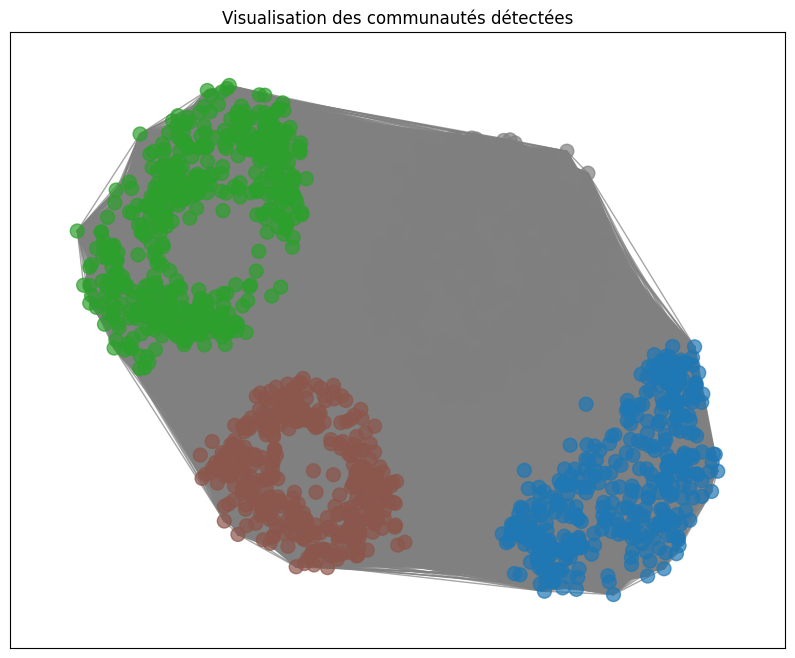

In [50]:
# Visualisation
G=generate_sbm_graph( [400, 390, 700, 500], [[0.8, 0.15, 0.2, 0.01], [0.15, 0.8, 0.12, 0.2], 
                                                 [0.2, 0.12, 0.7, 0.15], [0.01, 0.2, 0.15, 0.8]])
_,communities,_=find_best_community_partition(G , graph_to_adjacency_matrix(G), range(2,10))
visualize_graph(G, communities)